In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from unidip import UniDip
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder


def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    '''
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    '''
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


def plot_MoG_bounds(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    plot_MoG=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if plot_MoG:
            confidence_ellipse(x, z, axes[0], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
            confidence_ellipse(maxptp, z, axes[1], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
    
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-50, x.max()+50)
            axes[0].set_ylim(z.min()-100, z.max()+100)
            axes[1].set_xlim(0, maxptp.max()+30)
            axes[1].set_ylim(z.min()-100, z.max()+100)
        else:    
            axes[0].set_xlim(data[:,0].min()-10, data[:,0].max()+10)
            axes[0].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
            axes[1].set_xlim(data[:,2].min()-.5, data[:,2].max()+.5)
            axes[1].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('log-ptp')
    axes[1].set_ylabel('z (um)')
    if plot_MoG:
        axes[1].set_title(f'n_units = {len(np.unique(labels_display))}')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1)
        axes[1].spines[ax].set_linewidth(1)

    plt.tight_layout()
    plt.show()

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


load data

In [4]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [5]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

pca + unidip

In [29]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
alpha = 0.1
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        pca = PCA(n_components=1, svd_solver='full')
        features_trans = pca.fit_transform(sub_spike_features).flatten()
        n_gaussians = len(UniDip(features_trans, alpha = alpha).run())
        if n_gaussians == 0:
            n_gaussians = 1
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = GaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='kmeans', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

In [7]:
channel = 194 #251
sub_spike_times = spike_times[spike_channels == channel]
sub_spike_features = spike_features[spike_channels == channel]
sub_x, sub_z, sub_maxptp = sub_spike_features.T

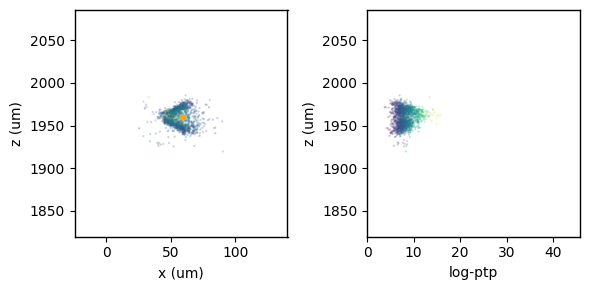

In [8]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=[channel], 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=False,
    figure_size=(6,3)
)

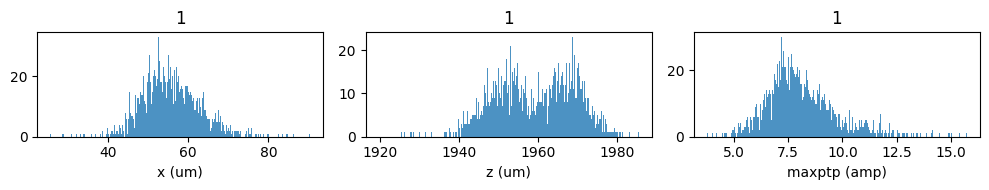

In [9]:
p_val = 0.05,
x_modes = UniDip(np.msort(sub_x), alpha=p_val).run()
n_modes_x = len(x_modes)
z_modes = UniDip(np.msort(sub_z), alpha=p_val).run()
n_modes_z = len(z_modes)
ptp_modes = UniDip(np.msort(sub_maxptp), alpha=p_val).run()
n_modes_ptp = len(ptp_modes)
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10, 2))
axes[0].hist(sub_x, 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(n_modes_x)
axes[1].hist(sub_z, 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_maxptp, 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

In [10]:
print(np.msort(sub_x)[x_modes])

[[25.59700012 90.39656067]]


In [11]:
print(np.msort(sub_z)[z_modes])

[[1941.19970703 1971.45947266]]


In [12]:
print(np.msort(sub_maxptp)[ptp_modes])

[[ 3.77316642 15.7256546 ]]


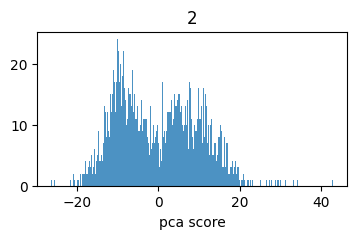

In [13]:
pca = PCA(n_components=1, svd_solver='full')
features_transformed = pca.fit_transform(sub_spike_features).flatten()

p_val = 0.05
n_tests = 1000
modes_idx = UniDip(np.msort(features_transformed), alpha=p_val, ntrials=n_tests).run()
n_gaussians = len(modes_idx)
plt.figure(figsize=(4,2))
plt.hist(features_transformed, 300, alpha=.8)
plt.xlabel('pca score')
plt.title(n_gaussians);

In [14]:
np.msort(features_transformed)[modes_idx]

array([[-11.96039072,  -5.11617257],
       [ -5.04872172,  17.27820966]])

In [15]:
np.argsort(features_transformed)[modes_idx]

array([[1190,  463],
       [  31,  933]])

In [16]:
def midpoint(xs, ys):
    return [(xs[0]+ys[0])/2, (xs[1]+ys[1])/2, (xs[2]+ys[2])/2]

In [17]:
orig_intervals = sub_spike_features[np.argsort(features_transformed)[modes_idx]]
orig_intervals

array([[[  60.24546432, 1971.75415039,    8.96897507],
        [  50.35203552, 1963.80944824,   10.0696125 ]],

       [[  50.51247406, 1963.78527832,    8.57715797],
        [  59.87669373, 1942.35644531,    6.40071154]]])

In [18]:
sub_means = [midpoint(orig_intervals[0][0], orig_intervals[0][1]),
                midpoint(orig_intervals[1][0], orig_intervals[1][1])]
sub_means

[[55.298749923706055, 1967.7817993164062, 9.519293785095215],
 [55.194583892822266, 1953.0708618164062, 7.488934755325317]]

In [19]:
# initialize MoG using unidip mode locations
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          means_init=sub_means,
                          warm_start=False, verbose=0).fit(sub_spike_features)

sub_labels = sub_gmm.predict(sub_spike_features)

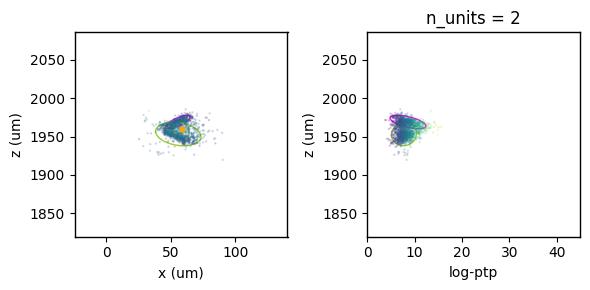

In [20]:
plot_MoG_bounds(
    data=sub_spike_features, 
    labels=sub_labels, 
    labels_display=np.unique(sub_labels), 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=True,
    figure_size=(6,3),
    n_spikes = 1_000
)

In [21]:
# initialize MoG using kmeans
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_features)
sub_labels = sub_gmm.predict(sub_spike_features)

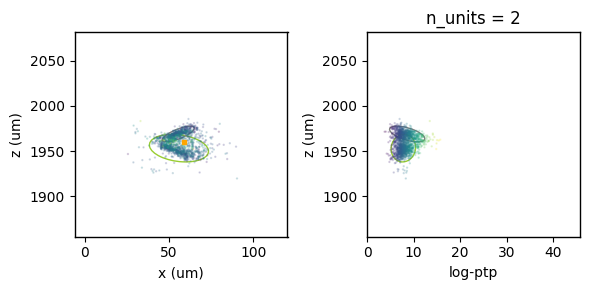

In [22]:
plot_MoG_bounds(
    data=sub_spike_features, 
    labels=sub_labels, 
    labels_display=np.unique(sub_labels), 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=True,
    figure_size=(6,3),
    n_spikes = 1_000
)

In [34]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                                 covariance_type='full')
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [35]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(8):
    print(f'loading batch {i+1} ..')
    spike_labels.extend(post_split_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(post_split_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

loading batch 1 ..
loading batch 2 ..
loading batch 3 ..
loading batch 4 ..
loading batch 5 ..
loading batch 6 ..
loading batch 7 ..
loading batch 8 ..


In [ ]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [21]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 503, 30)


In [ ]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [ ]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    choices, 
    behave_type='choice', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

In [ ]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    one_hot_stimuli, 
    behave_type='stimulus', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

In [25]:
# gmm_name = '../pretrained/danlab/Subjects/DY_016/init_max_chan_gmm'
# np.save(gmm_name + '_weights', post_split_gmm.weights_, allow_pickle=False)
# np.save(gmm_name + '_means', post_split_gmm.means_, allow_pickle=False)
# np.save(gmm_name + '_covariances', post_split_gmm.covariances_, allow_pickle=False)

merge

In [42]:
def kl_mvn(mu0, mu1, S0, S1):
    N = mu0.shape[0]
    inv_S1 = np.linalg.inv(S1)
    diff = mu1 - mu0
    tr_term   = np.trace(inv_S1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) 
    quad_term = diff.T @ np.linalg.inv(S1) @ diff 
    return .5 * (tr_term + det_term + quad_term - N) 

def symmetric_kl(mu0, mu1, S0, S1):
    kl1 = kl_mvn(mu0, mu1, S0, S1)
    kl2 = kl_mvn(mu1, mu0, S1, S0)
    return np.mean([kl1, kl2])

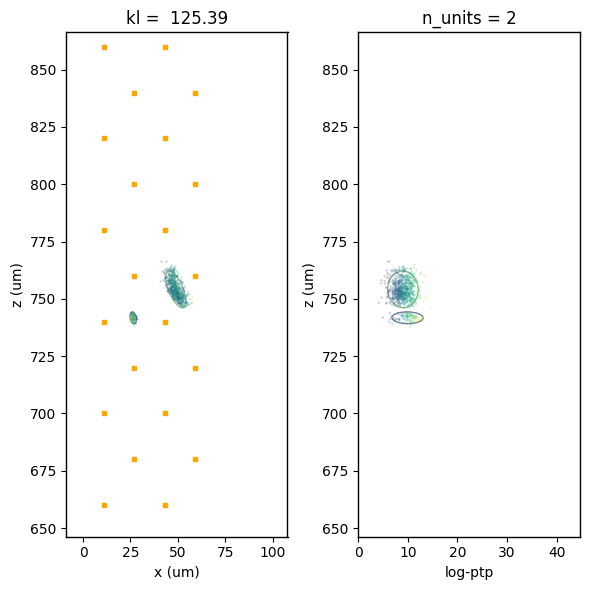

In [43]:
# example pairs:
    # [100, 101] should be merged 
    # [98, 99] should be kept
    # [100, 103] should be split 
    # [100, 104] should be split

labels = [98, 99] 

kl = symmetric_kl(mu0 = post_split_gmm.means_[labels[0]], 
       mu1 = post_split_gmm.means_[labels[1]], 
       S0 = post_split_gmm.covariances_[labels[0]], 
       S1 = post_split_gmm.covariances_[labels[1]])

plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=labels, 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels), 
    title=f'kl = {kl: .2f}',
    local=True,
    plot_MoG=True,
    figure_size=(6,6)
)

In [44]:
mask = np.logical_or(spike_labels == labels[0], spike_labels == labels[1])
sub_spike_times = spike_times[mask]
sub_spike_features = spike_features[mask]
sub_x, sub_z, sub_maxptp = sub_spike_features.T

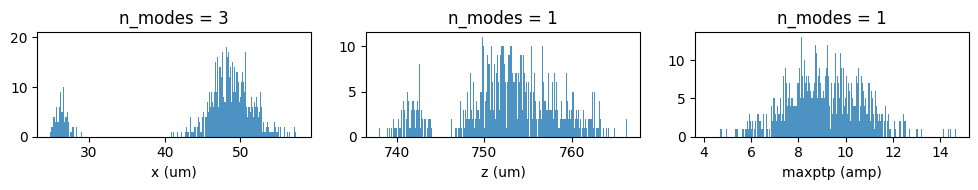

In [45]:
p_val = 0.01,
n_modes_x = len(UniDip(np.msort(sub_x), alpha=p_val).run())
n_modes_z = len(UniDip(np.msort(sub_z), alpha=p_val).run())
n_modes_ptp = len(UniDip(np.msort(sub_maxptp), alpha=p_val).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10, 2))
axes[0].hist(sub_x, 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(f'n_modes = {n_modes_x}')
axes[1].hist(sub_z, 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(f'n_modes = {n_modes_z}')
axes[2].hist(sub_maxptp, 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(f'n_modes = {n_modes_ptp}')
plt.tight_layout()
plt.show()

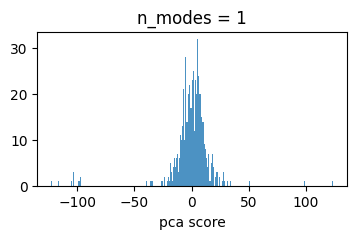

In [41]:
pca = PCA(n_components=1, svd_solver='full')
features_transformed = pca.fit_transform(sub_spike_features).flatten()

p_val = 0.01
n_tests = 1000
n_modes = len(UniDip(np.msort(features_transformed), alpha=p_val, ntrials=n_tests).run())
plt.figure(figsize=(4,2))
plt.hist(features_transformed, 300, alpha=.8)
plt.xlabel('pca score')
plt.title(f'n_modes = {n_modes}');

to do: roll it out on all pairs of gaussians ...